## IMPORTING LABRARIES

In [147]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

## Loading and Preprocessing Data

In [148]:
# Charger les données Titanic de Seaborn
data = sns.load_dataset('titanic')
data = data[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']].dropna()


## Cleaning Data

In [149]:
data

,survived,pclass,sex,age,sibsp,parch,embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S
...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,Q
886,0,2,male,27.0,0,0,S
887,1,1,female,19.0,0,0,S
889,1,1,male,26.0,0,0,C


In [150]:
# Fill numeric columns with median values
data = data.fillna(data.median(numeric_only=True))

data = data.drop_duplicates() # Remove rows with duplicated values


In [151]:
# Replace the 0 and 1 values in the 'sex' column with 'Male' and 'Female'
data['sex'].replace({0: 'male', 1: 'female'}).value_counts()
data['sex'].value_counts()

sex
male      306
female    234
Name: count, dtype: int64

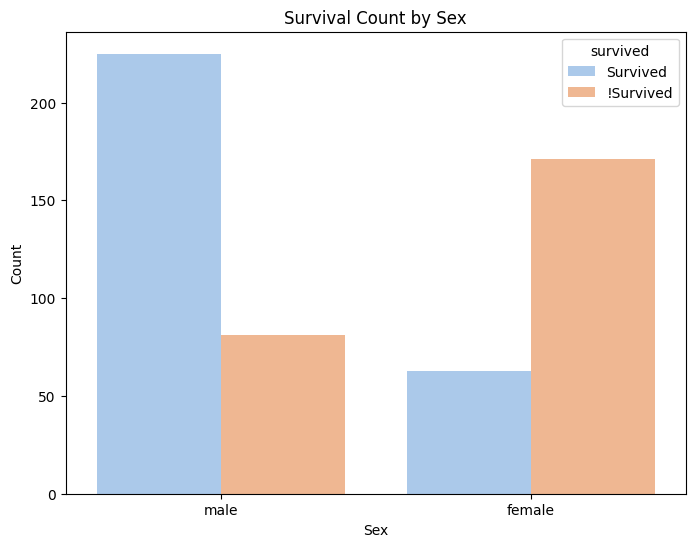

In [152]:
# Create a countplot for 'sex' and 'survived'
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', hue='survived', data=data, palette='pastel')


# Set labels and title
plt.title('Survival Count by Sex')
plt.xlabel('Sex')
plt.xticks()
plt.ylabel('Count')
plt.legend(title="survived",labels=["Survived","!Survived"])

# Show the plot
plt.show()

In [153]:
data['embarked'].replace({0:'C', 1:'Q', 2:'S'}).value_counts()
data['embarked'].value_counts()

embarked
S    397
C    116
Q     27
Name: count, dtype: int64

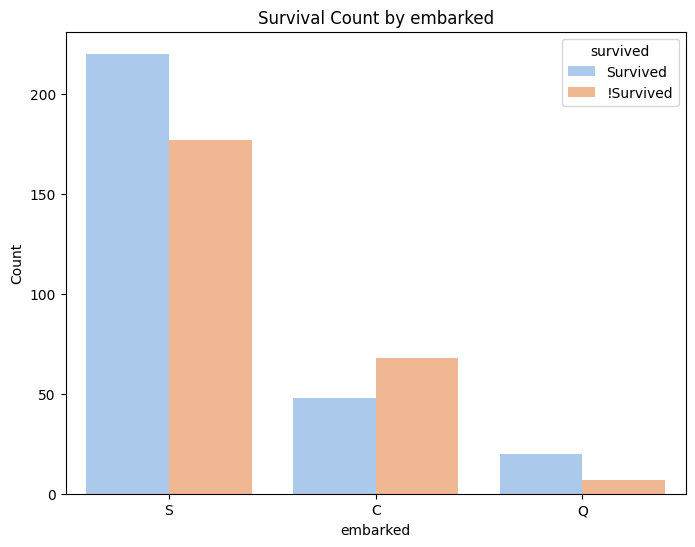

In [154]:
# Create a countplot for 'sex' and 'survived'
plt.figure(figsize=(8, 6))
sns.countplot(x='embarked', hue='survived', data=data, palette='pastel')


# Set labels and title
plt.title('Survival Count by embarked')
plt.xlabel('embarked')
plt.xticks()
plt.ylabel('Count')
plt.legend(title="survived",labels=["Survived","!Survived"])

# Show the plot
plt.show()

## Encoding Categorical Variables

In [155]:
# Encoder les variables catégoriques
data['sex'] = data['sex'].replace({'male': 0, 'female': 1})
data['embarked'] = data['embarked'].replace({'C': 0, 'Q': 1, 'S': 2})



C:\Users\pc\AppData\Local\Temp\ipykernel_24348\3503080433.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['sex'] = data['sex'].replace({'male': 0, 'female': 1})
C:\Users\pc\AppData\Local\Temp\ipykernel_24348\3503080433.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['embarked'] = data['embarked'].replace({'C': 0, 'Q': 1, 'S': 2})


## Splitting the Data

In [156]:
# Séparation des caractéristiques (X) et de la cible (y)
X = data.drop(columns='survived')  # Features
y = data['survived']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher les dimensions des jeux de données
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")



Training set size: 432 samples
Test set size: 108 samples


## Chi-Square Test Functions

In [157]:
# Approximation de la fonction Gamma pour les calculs
def gamma(n):
    # Stirling's approximation for large n
    if n > 1:
        return np.sqrt(2 * np.pi * n) * (n / np.e) ** n
    else:
        return 1  # Gamma(1) = 1


## the probability density function (PDF) for the Chi-squared distribution

In [158]:

def chi_square_pdf(chi2_stat, dof):
    if chi2_stat <= 0 or dof <= 0:
        return 0
    try:
        # Ensure stability by checking if the power calculation or exponential term goes out of bounds
        if chi2_stat > 1e10:  # Large chi-square statistic
            return 0
        term = (chi2_stat ** (dof / 2 - 1)) * np.exp(-chi2_stat / 2) / (2 ** (dof / 2) * gamma(dof / 2))
        if np.isnan(term) or np.isinf(term):
            return 0
        return term
    except Exception as e:
        print(f"Error in chi-square PDF calculation: {e}")
        return 0


## calculates the Cumulative Distribution Function (CDF) of the Chi-squared distribution

In [159]:
def chi_square_cdf(chi2_stat, dof):
    # Calculate CDF by numerical integration using the trapezoid rule
    x_vals = np.linspace(0, chi2_stat, 1000)  # Use a fine range of values for numerical integration
    y_vals = np.array([chi_square_pdf(x, dof) for x in x_vals])
    
    # Use trapezoid method from scipy.integrate for more stable integration
    cdf_value = trapezoid(y_vals, x_vals)
    return cdf_value

In [160]:
# Approximation de la fonction de distribution cumulative (CDF) du khi-deux pour calculer la p-value
def chi_square_p_value(chi2_stat, dof):
    return 1 - chi_square_cdf(chi2_stat, dof)


In [161]:
# Fonction pour calculer la statistique du khi-deux
def chi_square_test(observed):
    # Calculer les fréquences attendues
    expected = np.outer(observed.sum(axis=1), observed.sum(axis=0)) / observed.sum()
    
    # Calculer la statistique du khi-deux
    chi2_stat = np.sum((observed - expected) ** 2 / expected)
    
    # Calculer les degrés de liberté
    dof = (observed.shape[0] - 1) * (observed.shape[1] - 1)
    
    # Calculer la p-value à partir de la statistique du khi-deux et des degrés de liberté
    p_value = chi_square_p_value(chi2_stat, dof)
    
    return chi2_stat, p_value


## Feature Evaluation

In [162]:
# Fonction pour tester chaque variable
def evaluate_feature(data, feature, target='survived'):
    observed = pd.crosstab(data[feature], data[target])
    chi2_stat, p_value = chi_square_test(observed.values)
    return chi2_stat, p_value


## Node Class for CHAID Tree

In [163]:
# Classe de nœud de l’arbre CHAID
class Node:
    def __init__(self, feature=None, category=None, children=None, value=None):
        self.feature = feature
        self.category = category
        self.children = children or {}
        self.value = value


## CHAID Tree Construction

In [164]:
# Fonction pour construire l'arbre CHAID
def build_chaid_tree(data, target='survived', depth=0, max_depth=3):
    # Stop criteria: single class or max depth reached
    if len(np.unique(data[target])) == 1 or depth == max_depth:
        value = data[target].mode().iloc[0]
        return Node(value=value)
        # Select the best feature for split
    best_feature = None
    best_chi2 = 0 # we don't need the chi2 value for now
    best_p_value = 1  # Initialize with a high p-value
    
    for feature in data.columns.drop(target):
        chi2_stat, p_value = evaluate_feature(data, feature, target)
        if p_value < best_p_value:
            best_p_value = p_value
            best_chi2 = chi2_stat
            best_feature = feature
    if best_feature is None:
        return Node(value=data[target].mode().iloc[0])
    
    node = Node(feature=best_feature)
    for category in data[best_feature].unique():
        subset = data[data[best_feature] == category]
        node.children[category] = build_chaid_tree(subset, target, depth + 1, max_depth)
    
    return node



## Prediction Using the CHAID Tree

In [165]:
# Fonction pour prédire avec l'arbre CHAID
def predict(node, instance):
    if node.value is not None:
        return node.value
    feature_value = instance[node.feature]
    if feature_value in node.children:
        return predict(node.children[feature_value], instance)
    return None

def predict_tree(tree, data):
    return data.apply(lambda row: predict(tree, row), axis=1)


## Final Tree Visualization and Prediction Evaluation

In [166]:
from graphviz import Digraph

def visualize_chaid_tree(node, graph=None, parent_name=None, category=None):
    # Initialize graph on the first call
    if graph is None:
        graph = Digraph(format='pdf')
        graph.attr('node', shape='box')  # Set node shape to boxes for clarity

    # Define the current node's unique name
    node_name = f"{id(node)}"

    # Create label for the node based on its feature, category, or value
    if node.value is not None:
        label = f"Value: {'Survived' if node.value == 1 else 'Not Survived'}"
    elif node.category is not None:
        label = f"{node.feature} = {node.category}"
    else:
        label = f"Feature: {node.feature}"

    # Add the current node to the graph with the defined label
    graph.node(node_name, label)

    # Connect parent node to this node if a parent exists
    if parent_name is not None:
        edge_label = f"{category}" if category is not None else ""
        graph.edge(parent_name, node_name, label=edge_label)

    # Recursively visualize each child node
    for cat, child in node.children.items():
        visualize_chaid_tree(child, graph, node_name, category=cat)

    return graph



In [167]:
chaid_tree = build_chaid_tree(pd.concat([X_train,y_train],axis=1), target='survived', max_depth=3)

# Visualize the CHAID tree
tree_graph = visualize_chaid_tree(chaid_tree)
tree_graph.render("chaid_tree", view=True)  # Save and view the tree


# Evaluation des performances
predictions = predict_tree(chaid_tree, X_test)
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy*100:.2f}%")


Accuracy: 79.63%


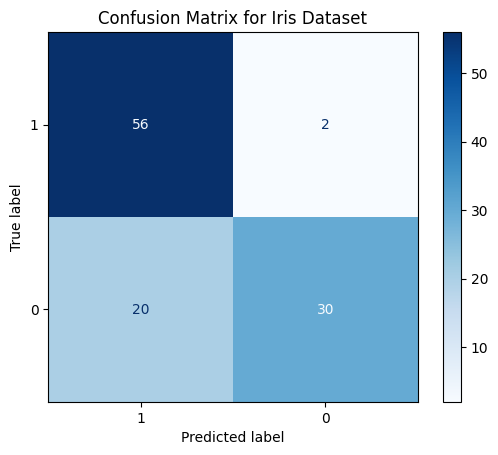

In [168]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Display the confusion matrix
unique_values = y_test.unique()
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_values)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Iris Dataset')
plt.show()

In [169]:
# Nouveau cas pour la prédiction
new_instance = pd.DataFrame({
    'age': [38],  # Numeric value
    'sex': ['female'],  # Categorical feature, to be encoded
    'pclass': [1],  # Categorical feature, using 3 as an example
    'sibsp': [0],  # Need to include this column as well
    'parch': [0],  # Include 'parch' column, even if it's not used in the decision tree
    'embarked': ['S'],  # Categorical feature, to be encoded
})

# Preprocess the new instance similarly to the training data
new_instance['sex'] = new_instance['sex'].map({'male': 0, 'female': 1})  # Encoding gender
new_instance['embarked'] = new_instance['embarked'].map({'C': 0, 'Q': 1, 'S': 2})  # Encoding embarked

# Prediction function (assuming `predict_tree` function is defined)
y_pred = predict_tree(chaid_tree, new_instance)

# Map 0 to 'Not Survived' and 1 to 'Survived'
y_pred_label = y_pred.map({0: 'Not Survived', 1: 'Survived'})

# Display the result
print("Prediction for new instance:", y_pred_label.iloc[0])


Prediction for new instance: Survived
